# Ajuste de la cantidad de parámetros de una Red Neuronal
# L2 (Ridge regression)
# Dropout

In [9]:
%load_ext autoreload
%autoreload 2
from IPython.display import HTML
import reg_helper as RHelper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


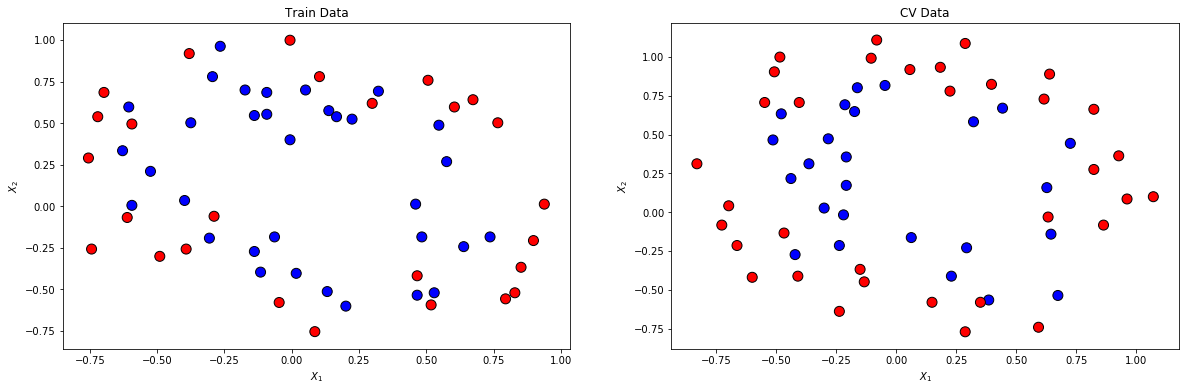

In [10]:
import numpy as np
import draw_nn
from matplotlib import pyplot as plt 
folder = 'data/'
X_train = np.load(folder+'X_train.npy')
X_test = np.load(folder+'X_test.npy')
y_train = np.load(folder+'y_train.npy') 
y_test = np.load(folder+'y_test.npy')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries(X_train, y_train, ax=ax1)
RHelper.plot_boundaries(X_test, y_test, ax=ax2)
ax1.set_title('Train Data')
ax2.set_title('CV Data')
ax1.set_xlabel('$X_1$')
ax1.set_ylabel('$X_2$')
ax2.set_xlabel('$X_1$')
ax2.set_ylabel('$X_2$')
plt.show()

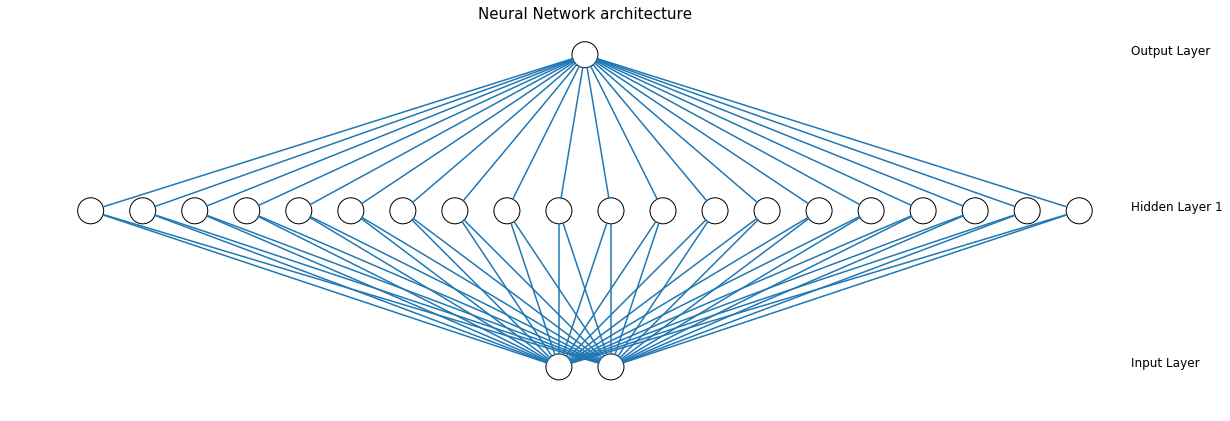

In [11]:
input_shape = 2
hidden_units = 20 # Probar con 3, 10, 20, 200
output_size = 1
network = draw_nn.DrawNN( [input_shape, hidden_units, output_size] )
network.draw()

<video controls src="./images/chips-mlp-20-hidden-1.mp4" width="480"/>

# Ejemplo de red neuronal con todo

In [12]:
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras import regularizers
from keras.constraints import max_norm
initializer='normal'

In [14]:
max_norm_value = 10
dropout = 0.5
l2_lambda = 1e-4
activation = 'sigmoid'

model = Sequential()
regularizer = regularizers.l2(l2_lambda)
model.add(Dense(hidden_units,input_dim=input_shape,  
                kernel_initializer=initializer, 
                bias_initializer=initializer,
                activation=activation, 
                kernel_regularizer=regularizer, 
                bias_regularizer=regularizer,
                kernel_constraint=max_norm(max_norm_value),
                bias_constraint=max_norm(max_norm_value)
               ))
model.add(Dropout(dropout))
model.add(Dense(output_size, 
            activation='sigmoid', 
            kernel_initializer=initializer, 
            bias_initializer=initializer,
            name='Salida',
            kernel_regularizer=regularizer, 
            bias_regularizer=regularizer
           ))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
Salida (Dense)               (None, 1)                 21        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


# La llamaremos desde la librería por comodidad

In [16]:
two_layer_model = RHelper.get_two_layer_model_L2(input_shape, output_size, hidden_units=hidden_units, lr=0.1, l2_lambda=0, decay=0.0)
two_layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                60        
_________________________________________________________________
Salida (Dense)               (None, 1)                 21        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


# Que opciones tenemos con Keras en una red neuronal:

- Regresión de Ridge L2 o L1
- max_norm (Constraints - Restricciones)
- Dropout
- Early stoping

Probar Relu y sigmoidea y ver diferencias

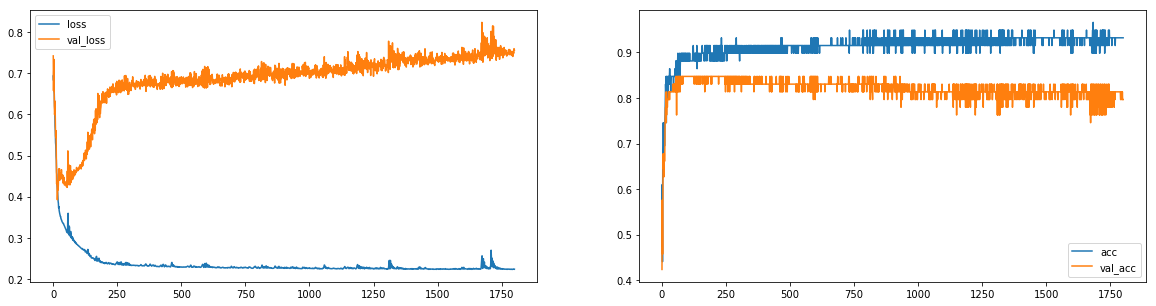

In [29]:
from fnn_helper import PlotLosses
from keras import optimizers
epochs = 2000 #adam 3000, sgd 30000
lr = 0.1
decay=0
hidden_units = 100
optim = optimizers.Adam(lr=lr) # cambiar a momentum 0.9 y lr a 5
batch_size = 59 # 10 y 59
activation='relu'
l2_lambda = 1e-4
dropout = None # 0.5
max_norm_value = None # 5 # None

plot_losses = PlotLosses(plot_interval=200, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
two_layer_model = RHelper.get_two_layer_model_L2(input_shape, 
                                                 output_size, 
                                                 hidden_units=hidden_units, 
                                                 # lr=lr, 
                                                 l2_lambda=l2_lambda, 
                                                 dropout=dropout,
                                                 decay=decay,
                                                 optim = optim,
                                                 activation=activation, 
                                                 max_norm_value=max_norm_value
                                                )
two_layer_model.fit(X_train, 
          y_train, batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses],
         )

¿Que diferencias se ven entre?
- ADAM y SGD. En cuanto a tiempos, curva de entrenamiento (monotona decreciente?)
- mini-batch size?
- con el decay?

In [32]:
# Para calcular norma en cada epoch
def get_weights_array(ws):
    weights_norm = []
    for weights in ws:
        weights_norm.append(np.linalg.norm(weights[0]))
    return weights_norm

59/59 [==============================] - 0s 31us/step


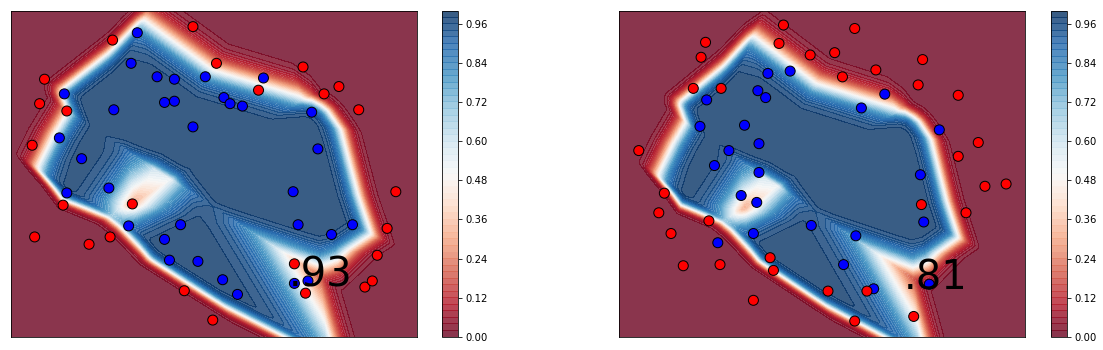

In [33]:
# two_layer_model.load_weights('SGD-3000-epochs-20-hu.hdf5')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries_keras(X_train, y_train, two_layer_model.evaluate(X_train, y_train)[1], two_layer_model.predict_proba, h = 0.01, margin=0.1, ax=ax1)
RHelper.plot_boundaries_keras(X_test, y_test, two_layer_model.evaluate(X_test, y_test)[1], two_layer_model.predict_proba, h = 0.01, margin=0.1, ax=ax2)
plt.show()

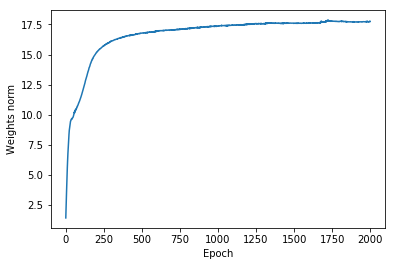

In [34]:
plt.plot(RHelper.get_weights_array(plot_losses.weights))
plt.xlabel('Epoch')
plt.ylabel('Weights norm')
plt.show()

# Diferencias fundamentales con Regresión logística
- No hay garantía de converger al mínimo absoluto
- Cada corrida puede dar resultados diferentes debido a la inicialización
- La función de activación tiene gran influencia en el resultado del modelo obtenido
- La regularización se aplica a nivel de capa
- Existe el concepto de regularización de activaciones y keras lo soporta (https://github.com/keras-team/keras/issues/1618)

# Dropout

- Elimina conexiones aleatoriamente al momento de entrenamiento (Especificamente, multiplica por cero algunas de las activaciones a la salida de una capa o eventualemente a la entrada de la red, aunque esto no es tan usual)
- keep_prob es la probabilidad de que las conexiones no se eliminen
- En keras se define el dropout_rate que es (1 - keep_prob)
- Al momento de entrenamiento, cuando se eliminan las conexiones, se dividen las salidas de las activaciones por 1/keep_prob para mantener en promedio lo que llega a la capa siguiente 
- En momento de evaluación no se eliminan conexiones.

<img src="./images/dropout.png" alt="Drawing" style="width:60%;"/>

**Tips:**  
- Usar un valor bajo entre 20% y 50%
- Usar una "red grande", muchos parámetros
- Usarlo tanto en la capa visible (entrada) como en las capas ocultas. La aplicación de dropout en cada capa a mostrado buenos resultados
- Usar un learning rate grande con decay y momentum. Incrementar el learning rate por un factor de 10 o hasta 100 y usar momentum del entre 0.9 y 0.99.
- Usar max-norm. Valores en el orden de 4 o 5 han mostrado buenos resultados

Referencias: [[1]](https://www.coursera.org/learn/deep-neural-network/lecture/eM33A/dropout-regularization), [[2]](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

# Busqueda de cantidad de parámetros

Correr varias veces y cambiar relu por sigmoidea

cantidad de unidades ocultas: 2, función de activación: relu


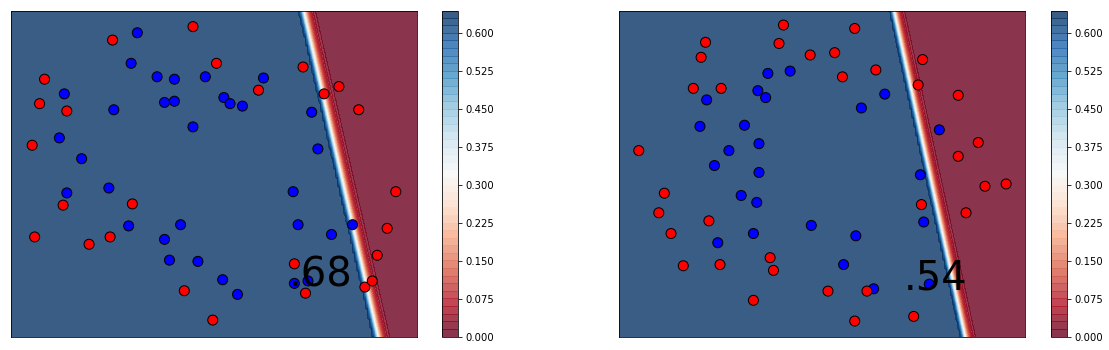

cantidad de unidades ocultas: 3, función de activación: relu


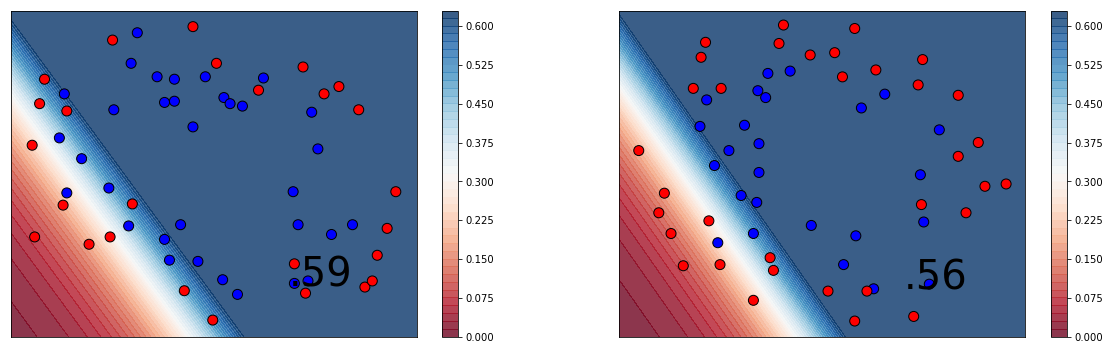

cantidad de unidades ocultas: 5, función de activación: relu


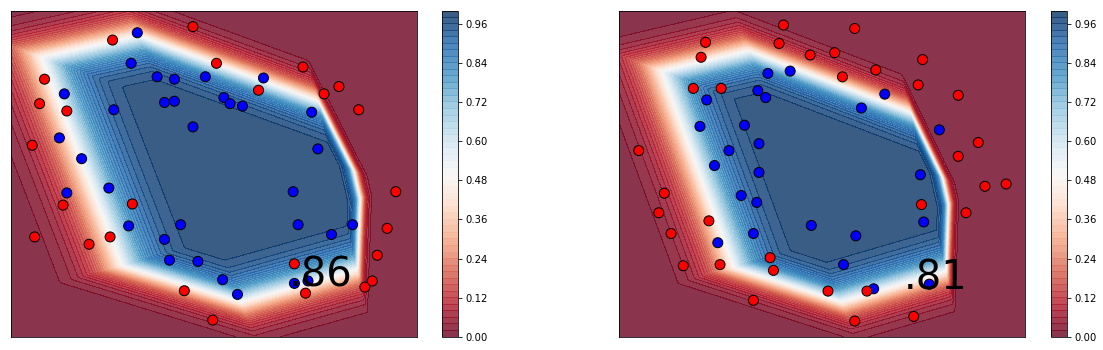

cantidad de unidades ocultas: 10, función de activación: relu


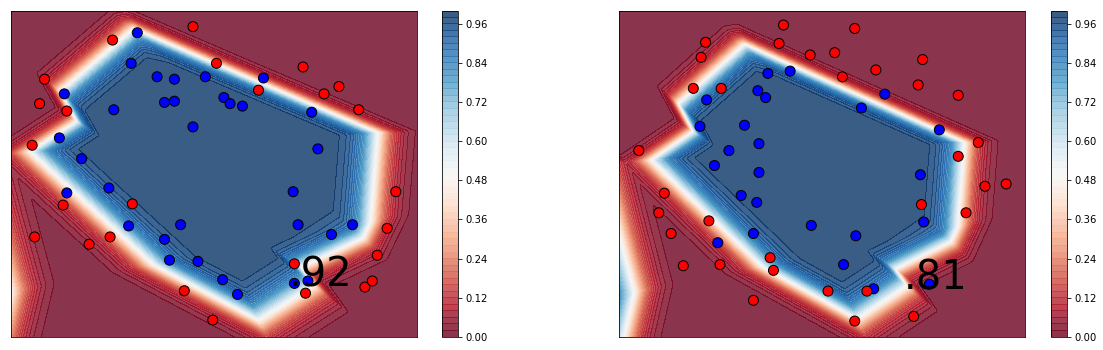

cantidad de unidades ocultas: 20, función de activación: relu


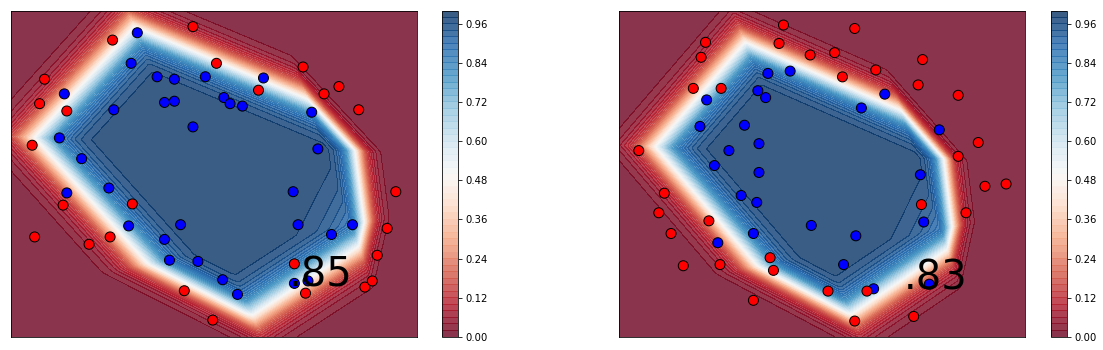

cantidad de unidades ocultas: 100, función de activación: relu


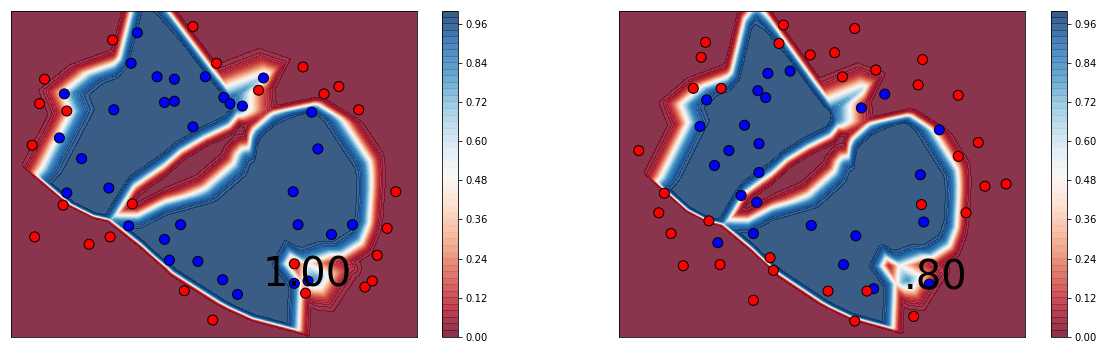

In [16]:
for hidden_units in [2, 3, 5, 10, 20, 100]:
    epochs = 2000 #adam 3000, sgd 30000
    lr = 0.1
    l2_lambda=0 #1e-3
    dropout=0
    decay=0
    # hidden_units = 20
    optim = optimizers.Adam(lr=lr) # cambiar a momentum 0.9 y lr a 5
    batch_size = 59 # 10 y 59
    activation='relu'

    plot_losses = PlotLosses(plot_interval=200, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
    two_layer_model = RHelper.get_two_layer_model_L2(input_shape, 
                                                     output_size, 
                                                     hidden_units=hidden_units, 
                                                     # lr=lr, 
                                                     l2_lambda=l2_lambda, 
                                                     decay=decay,
                                                     optim = optim,
                                                     activation=activation,
                                                     dropout=dropout
                                                    )
    two_layer_model.fit(X_train, 
              y_train, batch_size = batch_size,
              epochs=epochs, 
              verbose=0, 
              validation_data=(X_test, y_test), 
              callbacks=[],
             )
    print(f'cantidad de unidades ocultas: {hidden_units}, función de activación: {activation}')
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    RHelper.plot_boundaries_keras(X_train, y_train, two_layer_model.evaluate(X_train, y_train, verbose=0)[1], two_layer_model.predict_proba, h = 0.01, margin=0.1, ax=ax1)
    RHelper.plot_boundaries_keras(X_test, y_test, two_layer_model.evaluate(X_test, y_test, verbose=0)[1], two_layer_model.predict_proba, h = 0.01, margin=0.1, ax=ax2)
    plt.show()

cantidad de unidades ocultas: 2, función de activación: sigmoid


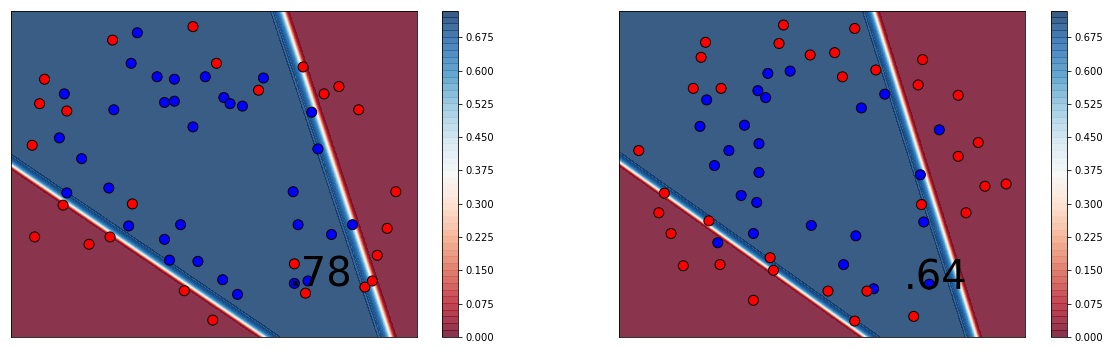

cantidad de unidades ocultas: 3, función de activación: sigmoid


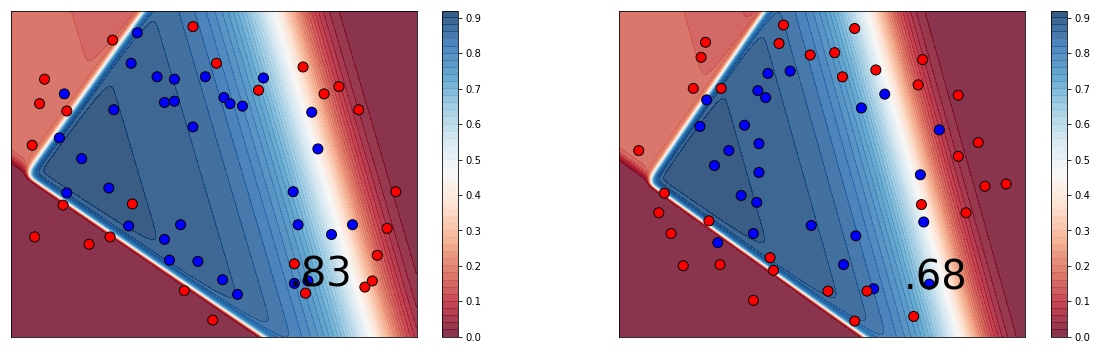

cantidad de unidades ocultas: 5, función de activación: sigmoid


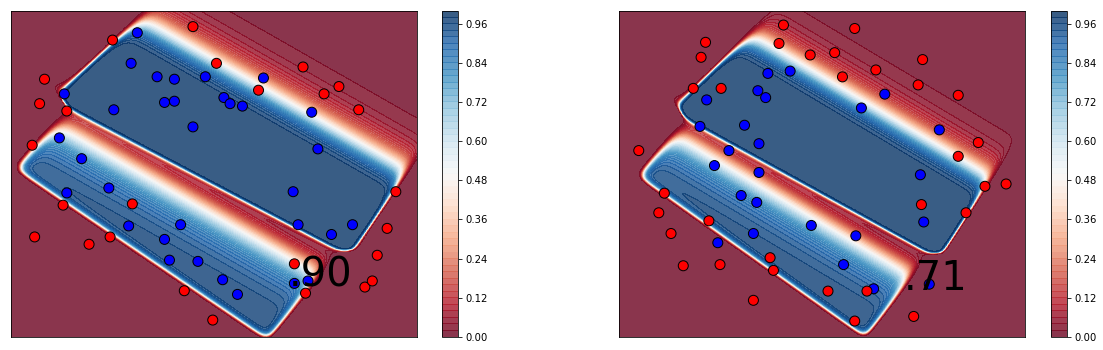

cantidad de unidades ocultas: 10, función de activación: sigmoid


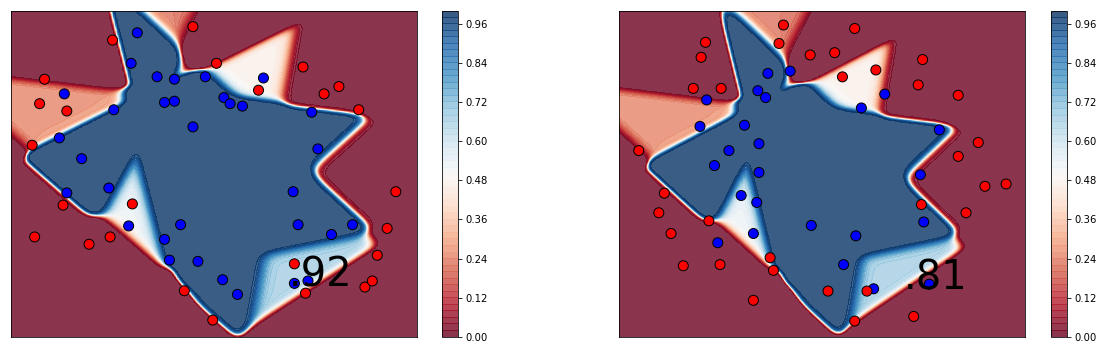

cantidad de unidades ocultas: 20, función de activación: sigmoid


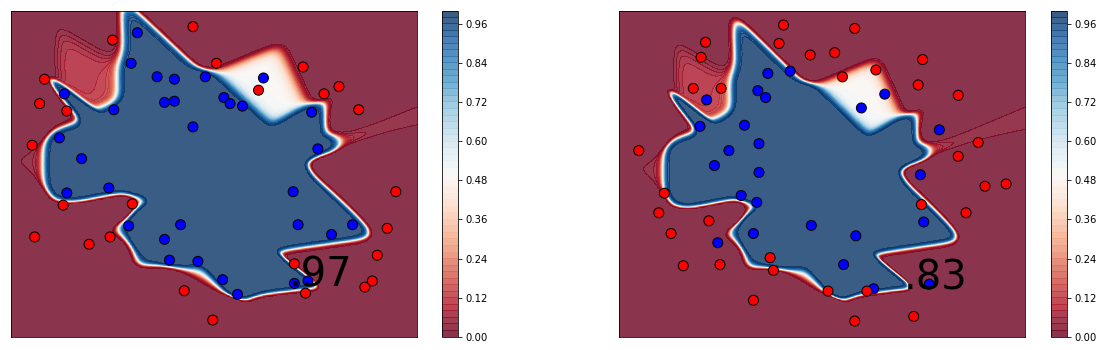

cantidad de unidades ocultas: 100, función de activación: sigmoid


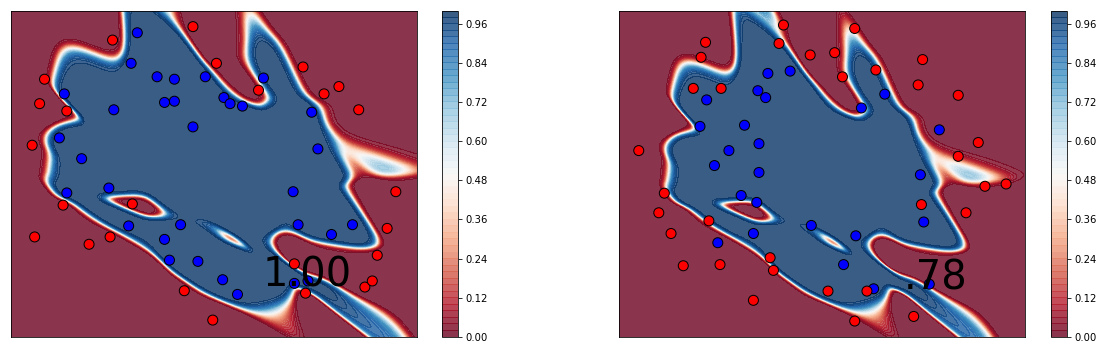

In [20]:
for hidden_units in [2, 3, 5, 10, 20, 100]:
    epochs = 2000 #adam 3000, sgd 30000
    lr = 0.1
    decay=0
    l2_lambda=0
    dropout=0
    # hidden_units = 20
    optim = optimizers.Adam(lr=lr) # cambiar a momentum 0.9 y lr a 5
    batch_size = 59 # 10 y 59
    activation='sigmoid'

    plot_losses = PlotLosses(plot_interval=200, evaluate_interval=None, x_val=X_test, y_val_categorical=y_test)
    two_layer_model = RHelper.get_two_layer_model_L2(input_shape, 
                                                     output_size, 
                                                     hidden_units=hidden_units, 
                                                     # lr=lr, 
                                                     l2_lambda=l2_lambda, 
                                                     decay=decay,
                                                     optim = optim,
                                                     activation=activation,
                                                     dropout=dropout
                                                    )
    two_layer_model.fit(X_train, 
              y_train, batch_size = batch_size,
              epochs=epochs, 
              verbose=0, 
              validation_data=(X_test, y_test), 
              callbacks=[],
             )
    print(f'cantidad de unidades ocultas: {hidden_units}, función de activación: {activation}')
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    RHelper.plot_boundaries_keras(X_train, y_train, two_layer_model.evaluate(X_train, y_train, verbose=0)[1], two_layer_model.predict_proba, h = 0.01, margin=0.1, ax=ax1)
    RHelper.plot_boundaries_keras(X_test, y_test, two_layer_model.evaluate(X_test, y_test, verbose=0)[1], two_layer_model.predict_proba, h = 0.01, margin=0.1, ax=ax2)
    plt.show()